In [15]:
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['font.family'] = 'dejavu sans'
mpl.rcParams['figure.dpi'] = 200
fs={'normal': 10, 'small':9, 'footnote':8, 'script':7, 'tiny':5, 'heading':12}

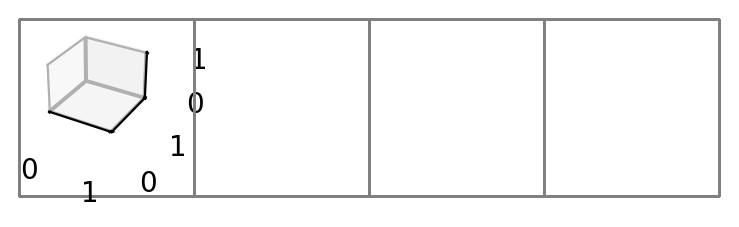

In [19]:
fig = plt.figure(figsize=(3.5, 1.5), linewidth=1, layout='compressed')
figs = fig.subfigures(1,4, wspace=0)
for subfig in figs:
    #fig0.frameon=True
    subfig.set_edgecolor('gray')
    subfig.set_linewidth(.5)

# cube: 

ax_cube = figs[0].subplots(subplot_kw={'projection': '3d'})